# Backtesting

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DecisionTransformerConfig, DecisionTransformerModel
from sklearn.model_selection import train_test_split
import ast
import itertools

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import INDICATORS

In [2]:
df = pd.read_csv("decision_transformer_ready_dataset.csv")

In [3]:
def parse_array(s):
    """
    Parses a string representation of a numpy array by direct manipulation.
    Handles multiple spaces, newlines, and scientific notation.
    """
    try:
        # Remove brackets and newlines, strip whitespace
        s_cleaned = s.replace('[', '').replace(']', '').replace('\n', '').strip()
        # Split by space
        parts = s_cleaned.split(' ')
        # Filter out empty strings from multiple spaces and convert to float
        return np.array([float(p) for p in parts if p != ''])
    except Exception as e:
        print(f"FATAL ERROR: Could not parse string: '{s}'")
        raise e
    
df['state'] = df['state'].apply(parse_array)
df['action'] = df['action'].apply(parse_array)

In [4]:
from dt_baseline import FinRLDataset, DecisionTransformerConfig, DecisionTransformerModel

df['episode_start'] = df['episode_start'].astype(bool)
episode_starts = df.index[df['episode_start']].tolist()
episode_indices = list(range(len(episode_starts)))
train_ep_indices, val_ep_indices = train_test_split(episode_indices, test_size=0.2, random_state=42)

train_df_indices = []
for ep_idx in train_ep_indices:
    start = episode_starts[ep_idx]
    end = episode_starts[ep_idx+1] if ep_idx + 1 < len(episode_starts) else len(df)
    train_df_indices.extend(range(start, end))

val_df_indices = []
for ep_idx in val_ep_indices:
    start = episode_starts[ep_idx]
    end = episode_starts[ep_idx+1] if ep_idx + 1 < len(episode_starts) else len(df)
    val_df_indices.extend(range(start, end))

train_df = df.iloc[train_df_indices].reset_index(drop=True)
val_df = df.iloc[val_df_indices].reset_index(drop=True)

CONTEXT_LENGTH = 20
train_dataset = FinRLDataset(train_df, context_len=CONTEXT_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

state_dim = train_dataset.state_dim
act_dim = train_dataset.action_dim

config = DecisionTransformerConfig(state_dim=state_dim, act_dim=act_dim, hidden_size=128, n_layer=3, n_head=1, n_inner=4*128)
model = DecisionTransformerModel(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/sally/miniconda3/envs/dt/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
TRADE_START_DATE = '2019-01-01'
TRADE_END_DATE = '2020-12-31'
trade_df = pd.read_csv('trade_data.csv')

trade_df = trade_df.set_index(trade_df.columns[0])
trade_df.index.names = ['']


stock_dimension = len(trade_df.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

eval_env = StockTradingEnv(df=trade_df, **env_kwargs)

Stock Dimension: 29, State Space: 291


In [6]:
def evaluate_episode_rtg(model, env, target_return):
    model.eval()
    state, _ = env.reset()
    state = np.array(state)
    done = False
    
    # Initialize with dummy action and reward for the first step
    states = torch.from_numpy(state).reshape(1, 1, state_dim).float().to(device)
    actions = torch.zeros((1, 1, act_dim), device=device)
    rewards_history = torch.zeros(1, 1, device=device)
    target_return_tensor = torch.tensor(target_return, device=device, dtype=torch.float32).reshape(1, 1, 1)
    timesteps = torch.tensor(0, device=device).reshape(1, 1)
    episode_return, episode_length = 0, 0
    
    while not done:
        # Manually create attention mask on the correct device
        seq_len = states.shape[1]
        attention_mask = torch.ones(1, seq_len, device=device, dtype=torch.long)
        
        action_preds = model(
            states=states,
            actions=actions,
            rewards=rewards_history,
            returns_to_go=target_return_tensor,
            timesteps=timesteps,
            attention_mask=attention_mask
        ).action_preds
        
        action = action_preds[0, -1].detach().cpu().numpy()
        state, reward, terminated, truncated, _ = env.step(action)
        state = np.array(state) 
        done = terminated or truncated

        # Update sequences
        actions = torch.cat([actions, torch.from_numpy(action).reshape(1, 1, act_dim).float().to(device)], dim=1)
        states = torch.cat([states, torch.from_numpy(state).reshape(1, 1, state_dim).float().to(device)], dim=1)
        rewards_history = torch.cat([rewards_history, torch.tensor([[reward]], device=device, dtype=torch.float32)], dim=1)
        
        # Ensure reward tensor has correct shape and device for subtraction
        reward_tensor = torch.tensor([[[reward]]], device=device, dtype=torch.float32)
        new_rtg = target_return_tensor[:, -1:, :] - reward_tensor
        target_return_tensor = torch.cat([target_return_tensor, new_rtg], dim=1)
        timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (episode_length + 1)], dim=1)
        episode_return += reward
        episode_length += 1

        # Trim sequences to context length
        states, actions, rewards_history, target_return_tensor, timesteps = (
            states[:, -CONTEXT_LENGTH:],
            actions[:, -CONTEXT_LENGTH:],
            rewards_history[:, -CONTEXT_LENGTH:],
            target_return_tensor[:, -CONTEXT_LENGTH:],
            timesteps[:, -CONTEXT_LENGTH:]
        )
        
    return env.save_asset_memory()

In [7]:
from finrl.plot import backtest_plot
from finrl.plot import backtest_stats, backtest_plot, get_daily_return

episode_starts = df.index[df['episode_start']].tolist()
episode_ends = episode_starts[1:] + [len(df)]
episode_returns = [df.iloc[start:end]['reward'].sum() for start, end in zip(episode_starts, episode_ends)]
target_return_prompt = np.mean(episode_returns)

print(f"\nEvaluating with a Target Return of: {target_return_prompt:.2f}")

model.load_state_dict(torch.load("decision_transformer_finrl.pth"))
account_value_df = evaluate_episode_rtg(model, eval_env, target_return_prompt)


Evaluating with a Target Return of: 439.31


[*********************100%***********************]  1 of 1 completed

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)



[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (334, 8)
Calculating performance stats...
Annual return          0.460033
Cumulative returns     0.653857
Annual volatility      0.231267
Sharpe ratio           1.755884
Calmar ratio           4.163693
Stability              0.924338
Max drawdown          -0.110487
Omega ratio            1.362256
Sortino ratio          3.038655
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.204649
Daily value at risk   -0.027525
dtype: float64
--- Performance Stats ---
Annual return          0.460033
Cumulative returns     0.653857
Annual volatility      0.231267
Sharpe ratio           1.755884
Calmar ratio           4.163693
Stability              0.924338
Max drawdown          -0.110487
Omega ratio            1.362256
Sortino ratio          3.038655
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.204649
Daily value at risk   -0.027525
dtype: float64
Generating backtest plot...
Shape of DataFrame:  


/home/sally/miniconda3/envs/dt/lib/python3.10/site-packages/finrl/plot.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/sally/miniconda3/envs/dt/lib/python3.10/site-packages/finrl/plot.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/sally/miniconda3/envs/dt/lib/python3.10/site-packages/finrl/plot.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=Non

Start date,2020-07-01
End date,2021-10-27
Total months,15
,Backtest
Annual return,46.003%
Cumulative returns,65.386%
Annual volatility,23.127%
Sharpe ratio,1.76
Calmar ratio,4.16
Stability,0.92
Max drawdown,-11.049%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.05,2020-09-02,2020-10-28,2020-11-09,49
1,7.52,2021-01-20,2021-01-29,2021-02-12,18
2,6.98,2021-07-12,2021-09-10,2021-09-24,55
3,6.71,2021-03-12,2021-03-23,2021-04-28,34
4,5.41,2020-12-04,2020-12-22,2021-01-06,24


/home/sally/miniconda3/envs/dt/lib/python3.10/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.16%,-3.66%,12.54%


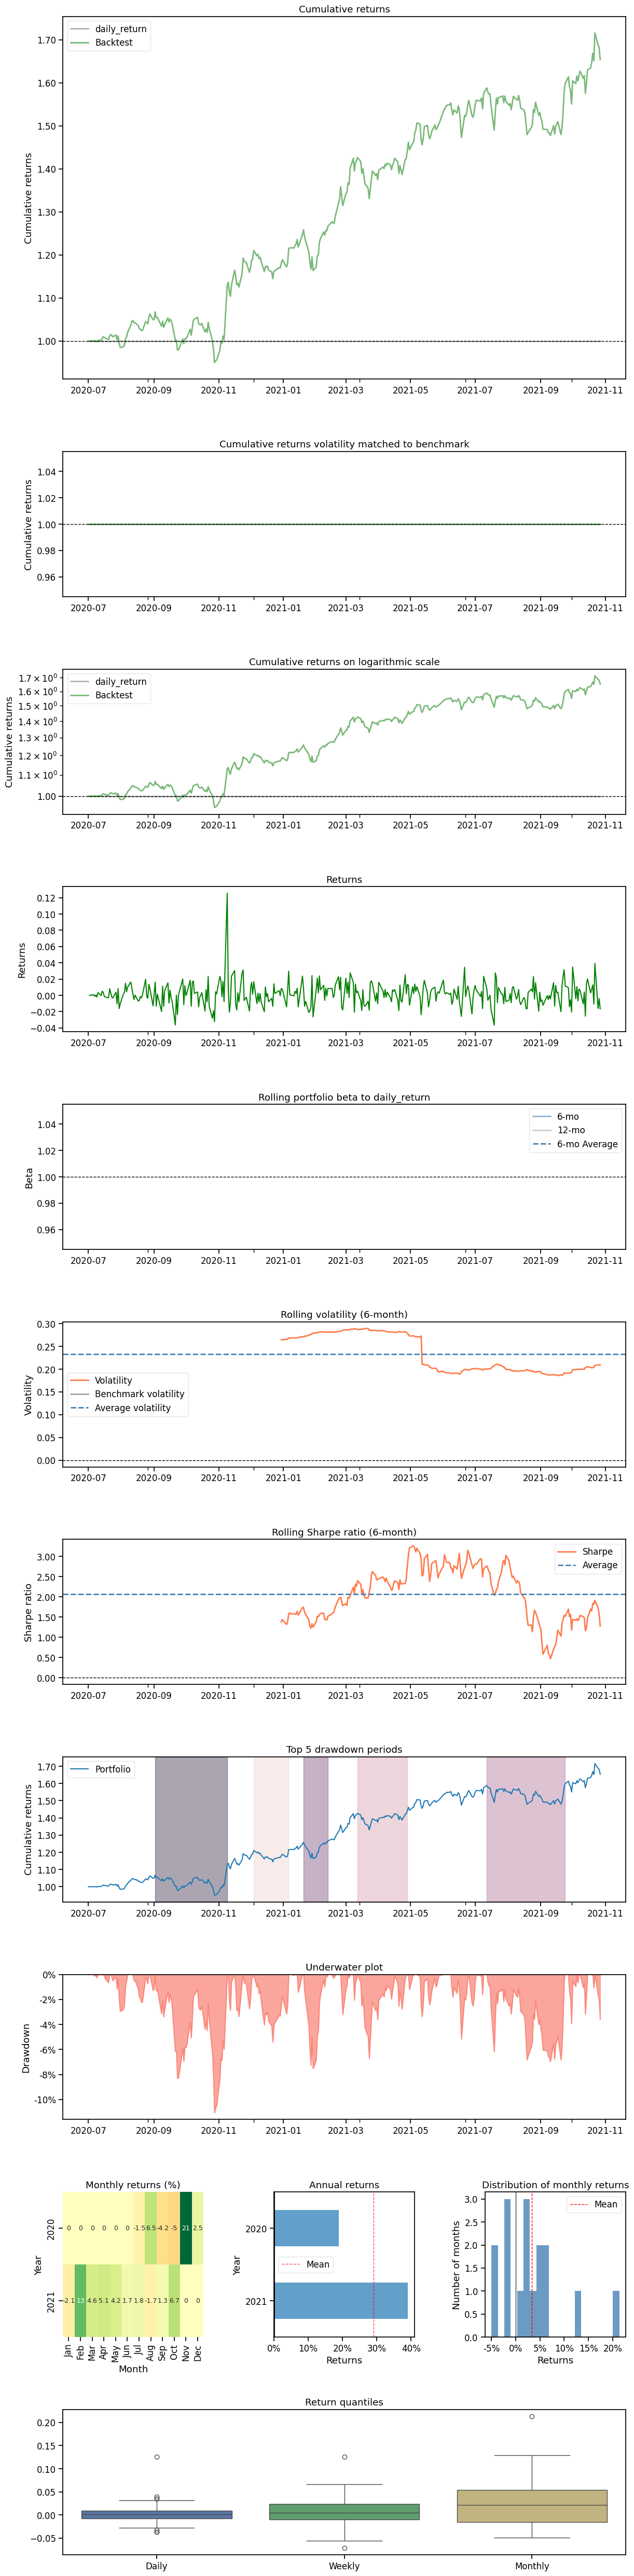

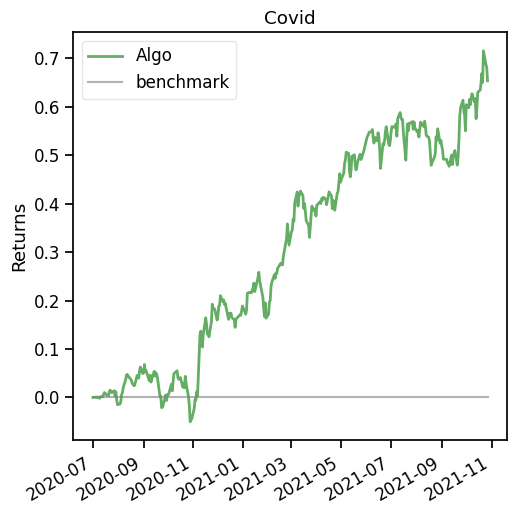

In [8]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import matplotlib.pyplot as plt
%matplotlib inline

benchmark_ticker = 'QQQ' # Nasdaq 100

start_date = account_value_df.date[0]
end_date = account_value_df.date[len(account_value_df)-1]

baseline_df = get_baseline(
    ticker=benchmark_ticker,
    start=start_date,
    end=end_date
)

#  Normalize and merge the baseline data
baseline_df['baseline'] = baseline_df['close'] / baseline_df['close'].iloc[0] * account_value_df['account_value'].iloc[0]
account_value_with_baseline = pd.merge(account_value_df, baseline_df[['baseline']], how='left', left_index=True, right_index=True)

# rename the first column 'index' to 'date'
account_value_to_plot = account_value_with_baseline.rename(columns={'index': 'date'})

print("Calculating performance stats...")
perf_stats_all = backtest_stats(account_value=account_value_to_plot)

print("--- Performance Stats ---")
print(perf_stats_all)

print("Generating backtest plot...")
backtest_plot(account_value=account_value_to_plot)

In [9]:
annual_return = f"{perf_stats_all.loc['Annual return']*100:.2f}%"
sharpe_ratio = f"{perf_stats_all.loc['Sharpe ratio']:.2f}"
max_drawdown = f"{perf_stats_all.loc['Max drawdown']*100:.2f}%"
volatility = f"{perf_stats_all.loc['Annual volatility']*100:.2f}%"
# Calculate Total Return from the account value
total_return = ( (account_value_to_plot['account_value'].iloc[-1] / account_value_to_plot['account_value'].iloc[0]) - 1 ) * 100
total_return_str = f"{total_return:.2f}%"

stats_text = (
    f"Total Return: {total_return_str}\n"
    f"Annual Return: {annual_return}\n"
    f"Sharpe Ratio: {sharpe_ratio}\n"
    f"Max Drawdown: {max_drawdown}\n"
    f"Volatility: {volatility}"
)
print(stats_text)

Total Return: 65.39%
Annual Return: 46.00%
Sharpe Ratio: 1.76
Max Drawdown: -11.05%
Volatility: 23.13%


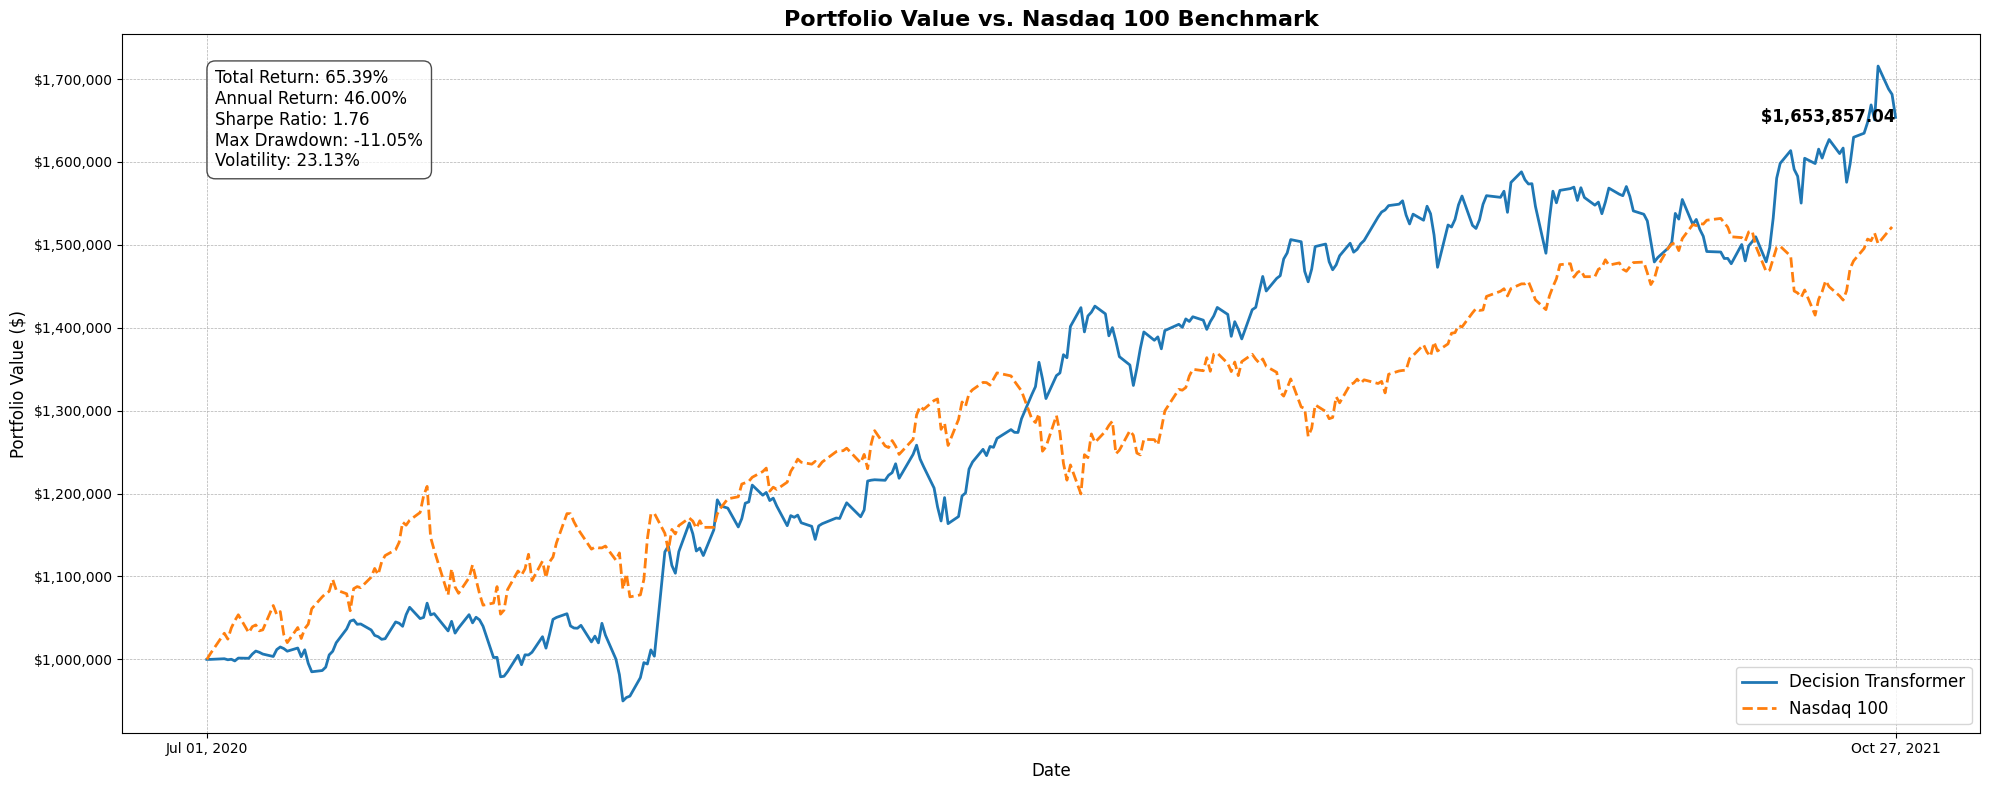

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(20, 8))
account_value_to_plot['date'] = pd.to_datetime(account_value_to_plot['date'])

# Decision Transformer's portfolio value
ax.plot(account_value_to_plot['date'], account_value_to_plot['account_value'], lw=2, label='Decision Transformer')

# baseline (benchmark)
ax.plot(account_value_to_plot['date'], account_value_to_plot['baseline'], lw=2, linestyle='--', label='Nasdaq 100')

ax.set_title('Portfolio Value vs. Nasdaq 100 Benchmark', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)

# Format the y-axis to show dollar values
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xticks([start_date, end_date])

# Format the labels for these specific ticks for readability
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))

# Add a legend and grid
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

# Add a final annotation for the portfolio value
final_value = account_value_to_plot['account_value'].iloc[-1]
ax.text(account_value_to_plot['date'].iloc[-1], final_value, f' ${final_value:,.2f}',
        verticalalignment='center', fontsize=12, fontweight='bold', ha='right')

ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

plt.tight_layout()
fig.savefig('backtest_plot.png', dpi=300)
plt.show()